# Toxicity Classification:

### 1. Business Problem:

**Source:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br><br>
**Description:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description<br><br>
**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.<br><br>

### 2. Machine Learning Problem Formulation:

#### 2.1 Data: <br>

- Source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit
    - Comment_text data also has identity attributes carved out from it, some of which are:
        - male
        - female
        - homosexual_gay_or_lesbian
        - christian
        - jewish
        - muslim
        - black
        - white
        - asian
        - latino
        - psychiatric_or_mental_illness
    - Apart from above features the train data also provides meta-data from jigsaw like:
        - toxicity_annotator_count
        - identity_anotator_count
        - article_id
        - funny
        - sad
        - wow
        - likes
        - disagree
        - publication_id
        - parent_id
        - article_id
        - created_date
        

#### 2.2 Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** Why would you assume that the nurses in this story were women?<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



#### 2.3 Type of Machine Learning Problem:<br>

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.



#### 2.4 Performance Metric:

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>
More on evaluation: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation



#### 2.5 Machine Learning Objectives and Constraints:<br>

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

## Importing Libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding
import warnings
from keras import backend as K

warnings.filterwarnings("ignore")

# Check for available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print("  -", gpu.name)
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Total number of GPUs:", len(gpus))
        print("Total number of logical GPUs:", len(logical_gpus))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs available.")

# Import CuDNNLSTM layer if available, fallback to LSTM otherwise
try:
    from keras.layers import CuDNNLSTM
except ImportError:
    CuDNNLSTM = LSTM


2024-04-13 17:55:28.625896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 17:55:28.626030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 17:55:28.882611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Available GPUs:
  - /physical_device:GPU:0
  - /physical_device:GPU:1
Total number of GPUs: 2
Total number of logical GPUs: 1


## Reading Data:

In [4]:
train_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
test_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [6]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                            

In [8]:
train_df.isnull().sum()

target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**No Null values for target and comment_text columns**

In [9]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

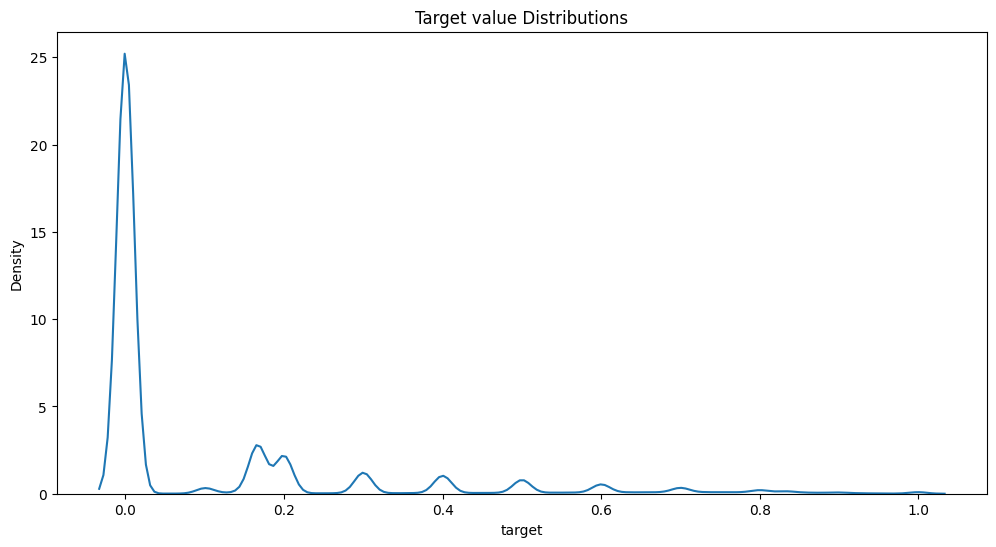

In [10]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

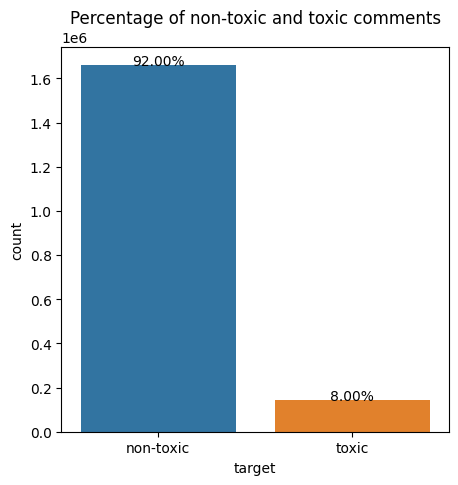

In [11]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
total = float(len(temp))

# Plot the count plot directly using the Series.
cntplot = sns.countplot(x=temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3, '{:1.2f}%'.format(100 * height / total), ha='center')

plt.show()


**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [12]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

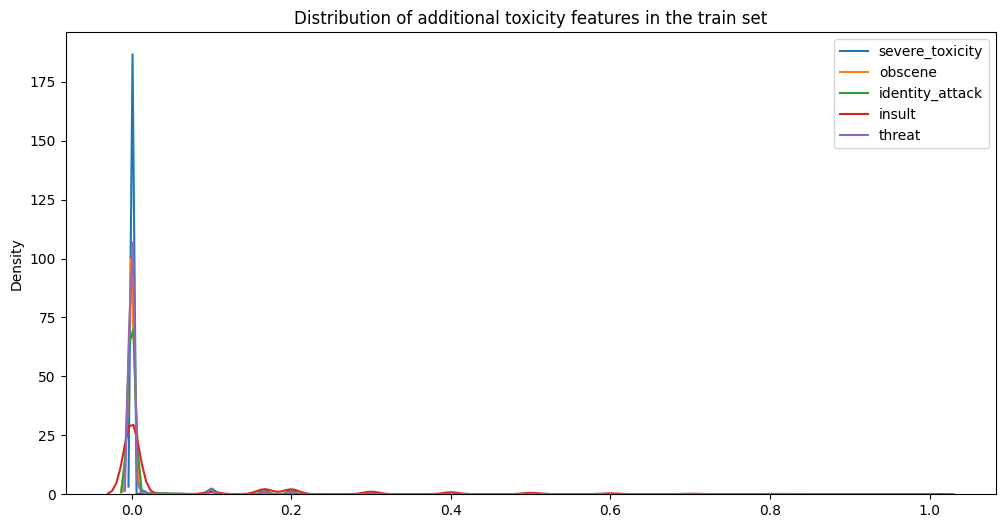

In [13]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

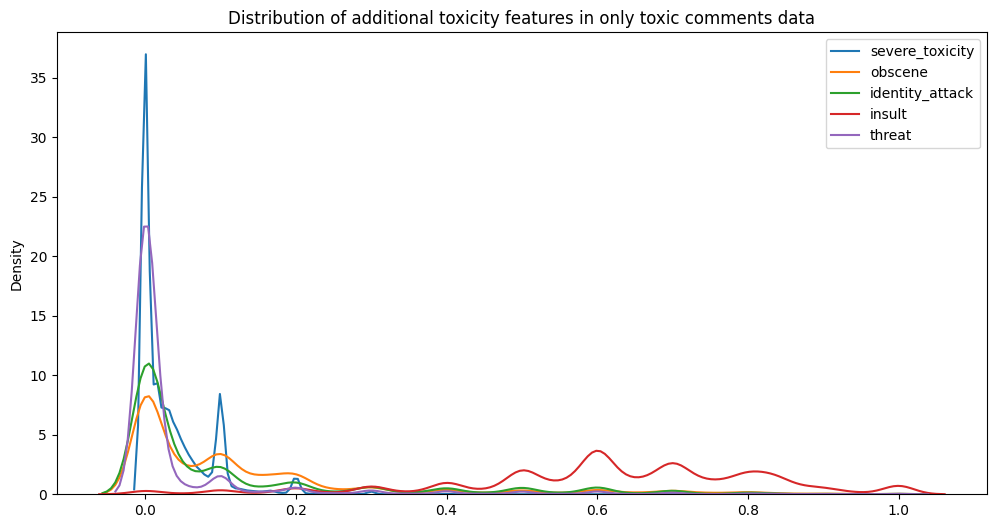

In [14]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [15]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

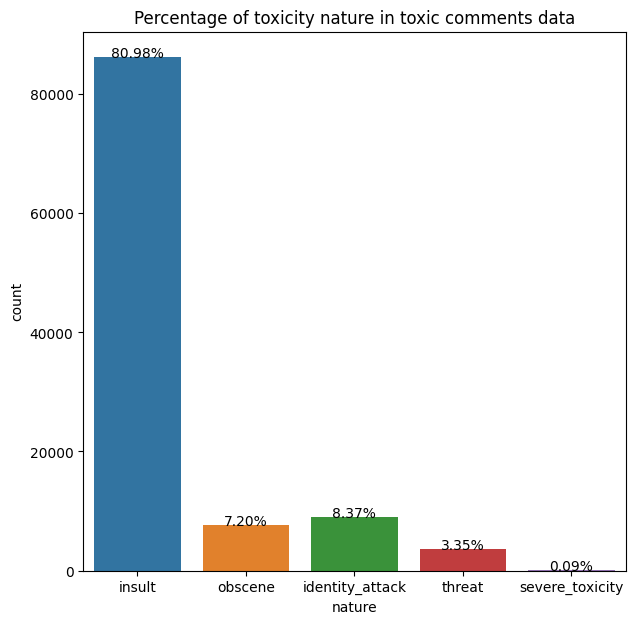

In [16]:
# Assuming temp is a DataFrame and get_comment_nature is a function
temp['nature'] = temp.apply(get_comment_nature, axis=1)  # Create a new column 'nature' with the result of get_comment_nature

# Plot the count plot.
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(temp['nature']))

cntplot = sns.countplot(x='nature', data=temp)  # Use the 'nature' column as x
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3, '{:1.2f}%'.format(100 * height / total), ha='center')

plt.show()


**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [17]:
temp = train_df.dropna(axis = 0, how = 'any')

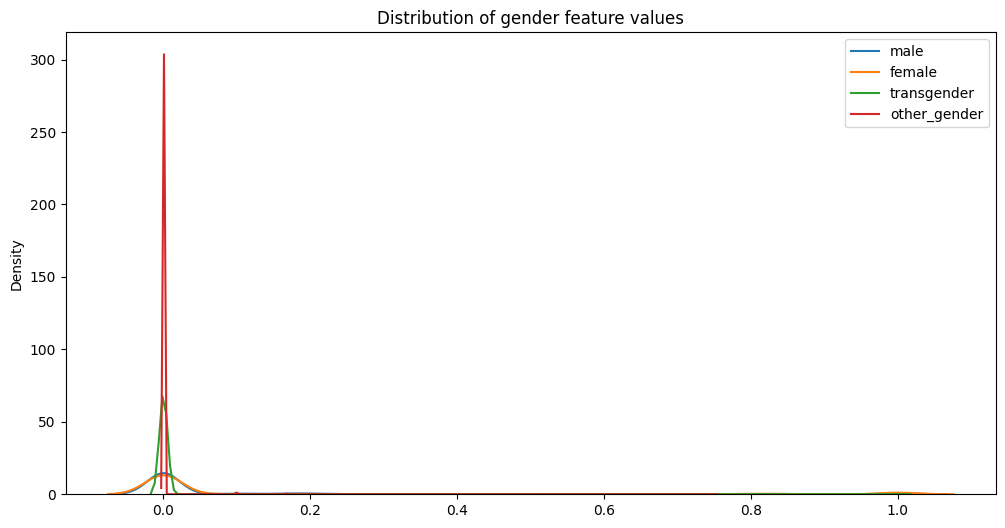

In [18]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

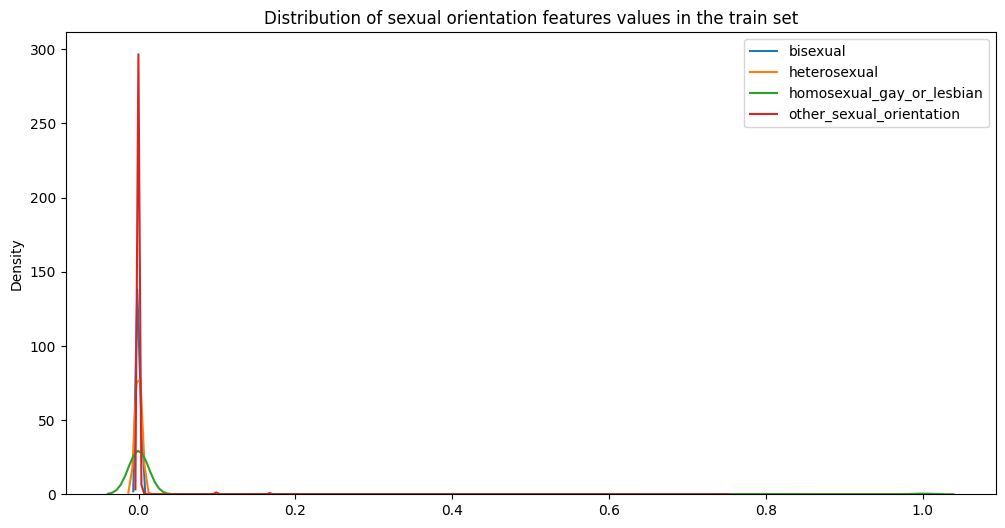

In [19]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

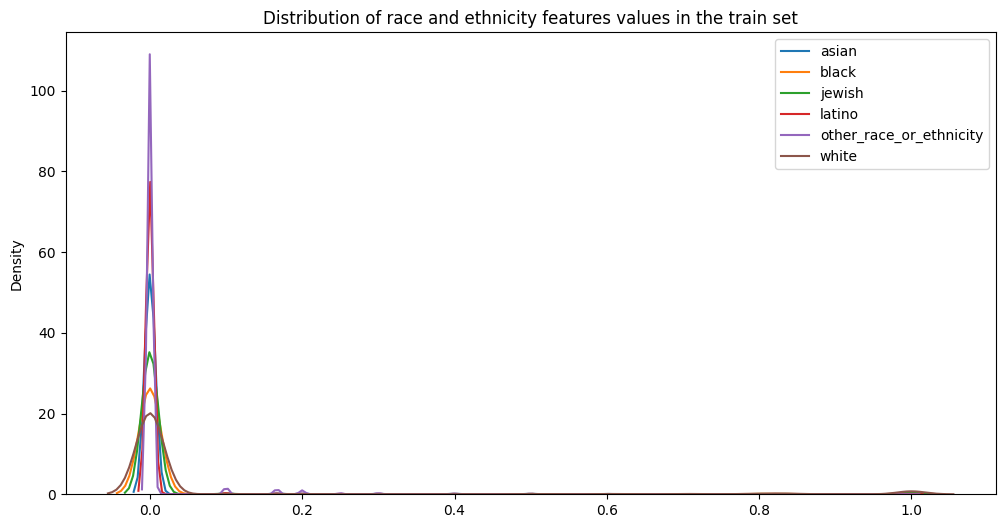

In [20]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

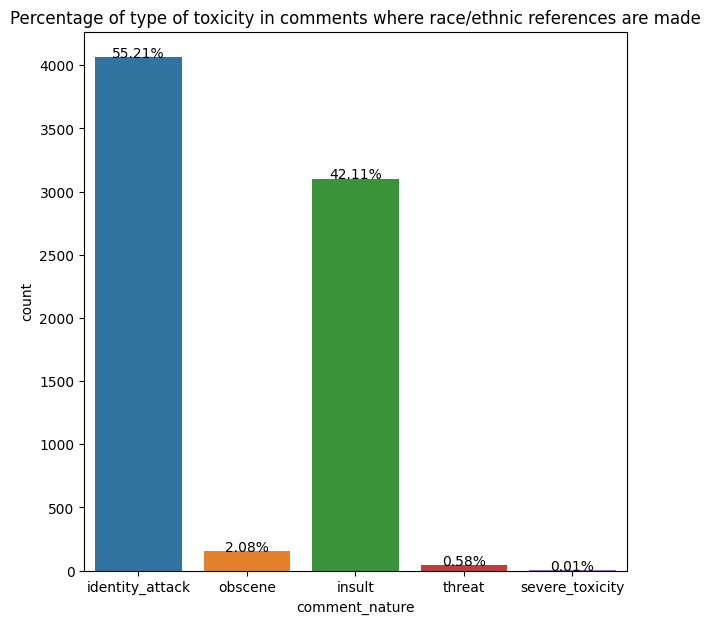

In [21]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond]  # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5]  # Extract only toxic comments.

# Assuming get_comment_nature returns the nature of each toxic comment
temp['comment_nature'] = temp.apply(get_comment_nature, axis=1)  # Get nature of each toxic comment

# Count the occurrences of each comment nature
x = temp['comment_nature'].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(temp))

# Plot the count plot using the counts of comment natures
cntplot = sns.countplot(x=temp['comment_nature'])
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3, '{:1.2f}%'.format(100 * height / total), ha='center')

plt.show()


**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

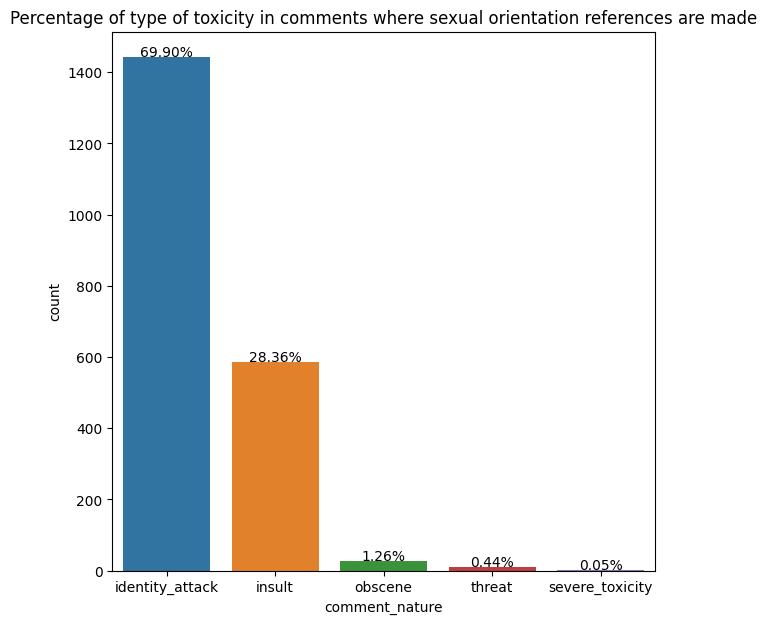

In [22]:
# Get data where sexual orientation references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond]  # Get data where sexual orientation references are made.
temp = temp[temp['target'] > 0.5]  # Extract only toxic comments.

# Assuming get_comment_nature returns the nature of each toxic comment
temp['comment_nature'] = temp.apply(get_comment_nature, axis=1)  # Get nature of each toxic comment

# Count the occurrences of each comment nature
x = temp['comment_nature'].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(temp))

# Plot the count plot using the counts of comment natures
cntplot = sns.countplot(data=temp, x='comment_nature')
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3, '{:1.2f}%'.format(100 * height / total), ha='center')

plt.show()


**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

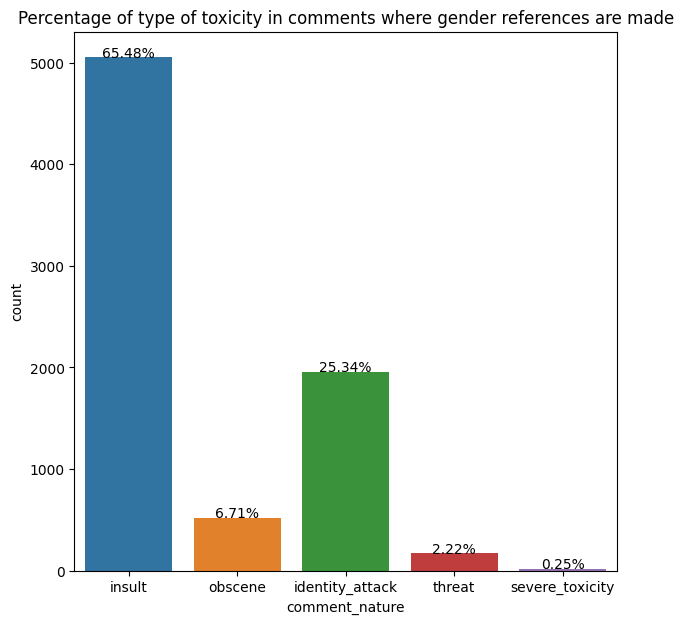

In [23]:
# Get data where gender references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond]  # Get data where gender references are made.
temp = temp[temp['target'] > 0.5]  # Extract only toxic comments.

# Assuming get_comment_nature returns the nature of each toxic comment
temp['comment_nature'] = temp.apply(get_comment_nature, axis=1)  # Get nature of each toxic comment

# Count the occurrences of each comment nature
x = temp['comment_nature'].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(temp))

# Plot the count plot using the counts of comment natures
cntplot = sns.countplot(data=temp, x='comment_nature')
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3, '{:1.2f}%'.format(100 * height / total), ha='center')

plt.show()


**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [24]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

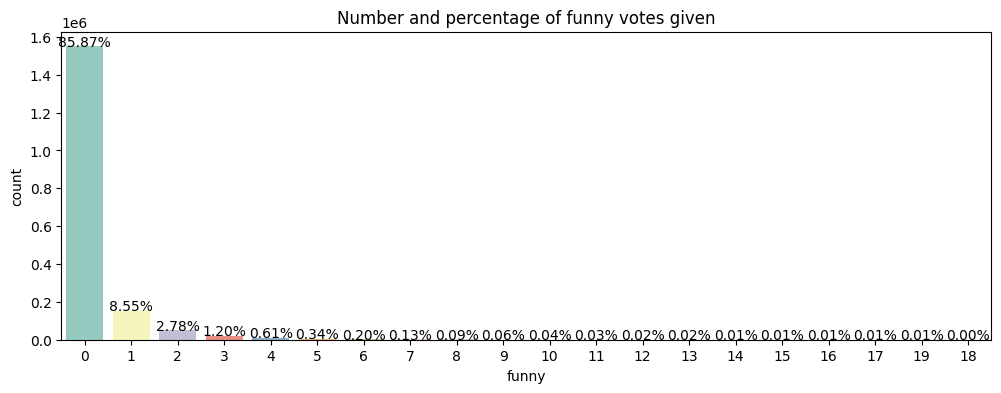

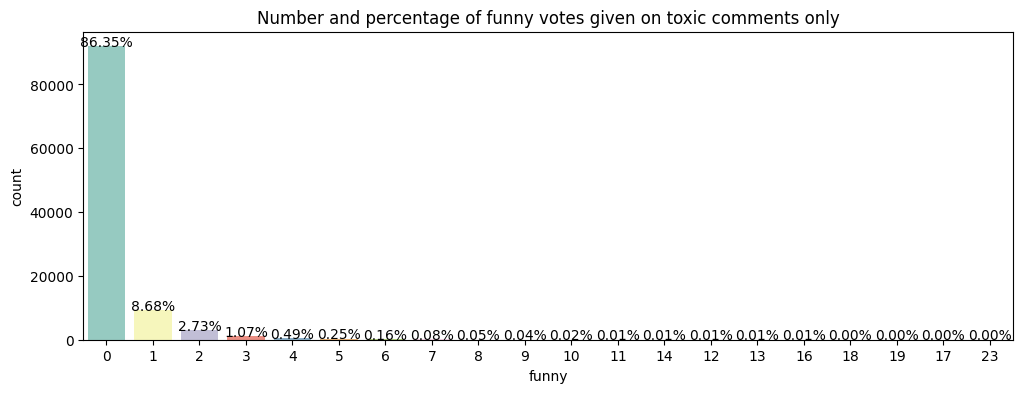

In [25]:
def plot_count(feature, title, data, size):
    """
    Plot count of different categories in the feature
    """
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data=data, x=feature, order=data[feature].value_counts().iloc[:20].index, palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)


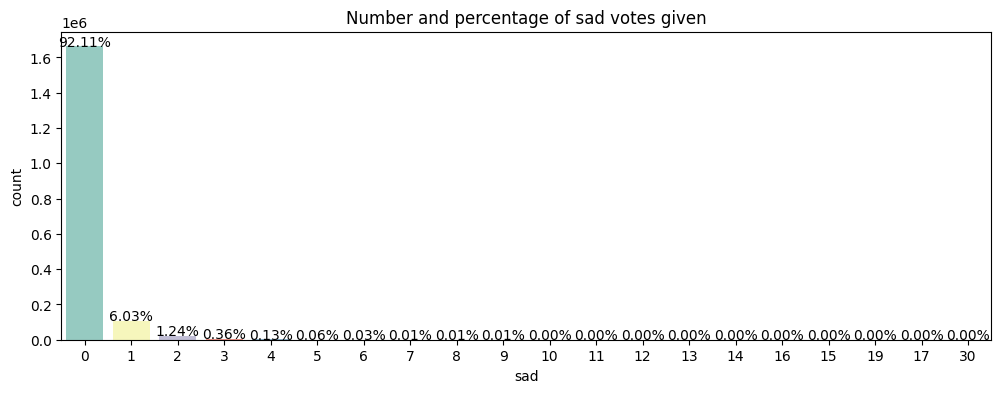

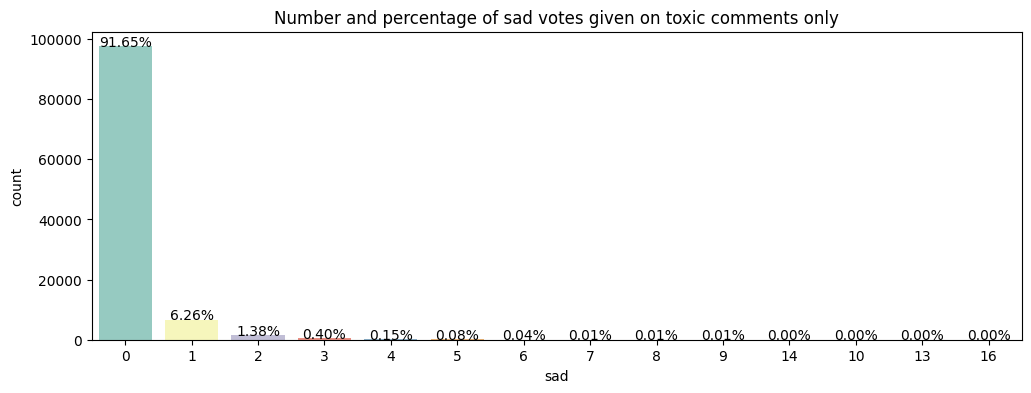

In [26]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

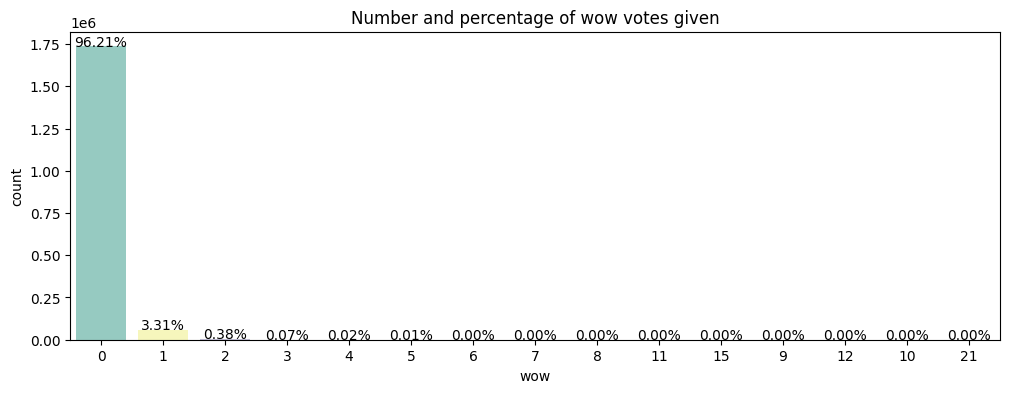

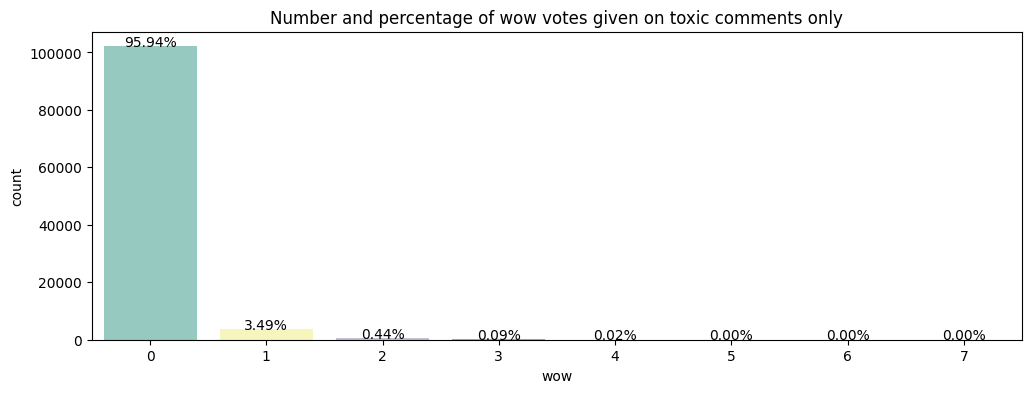

In [27]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

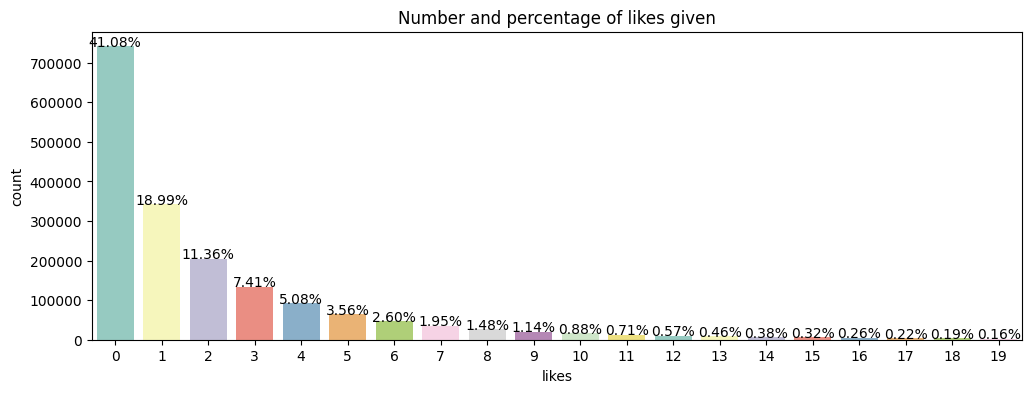

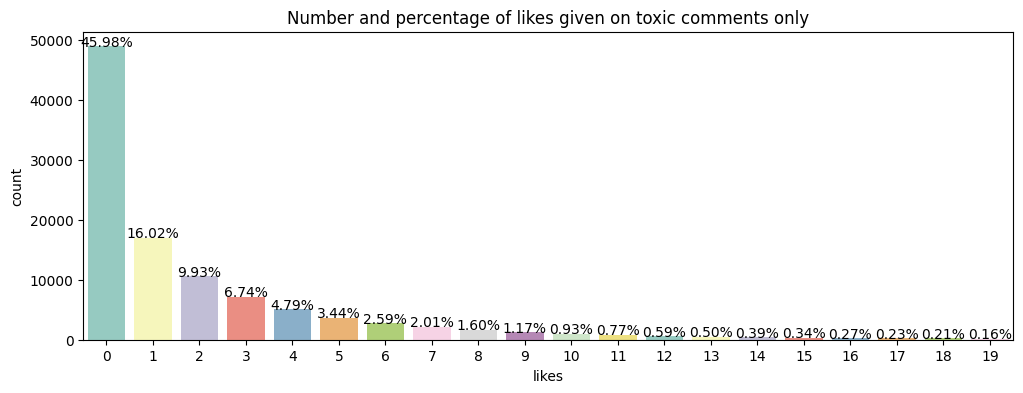

In [28]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

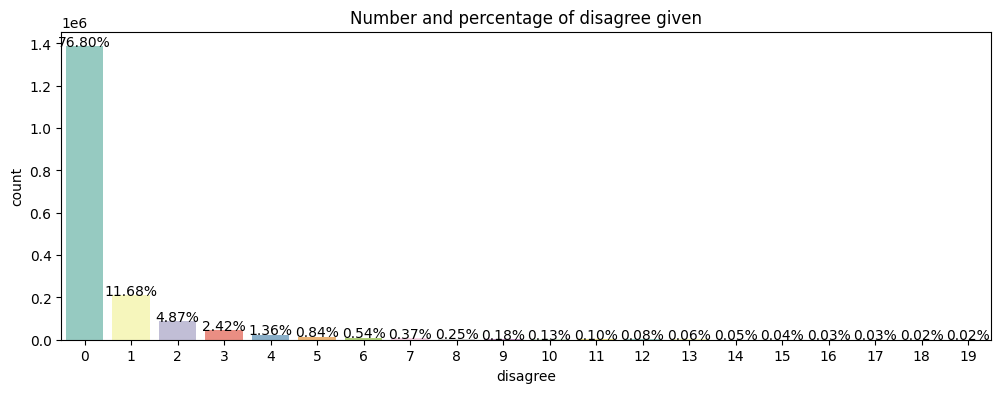

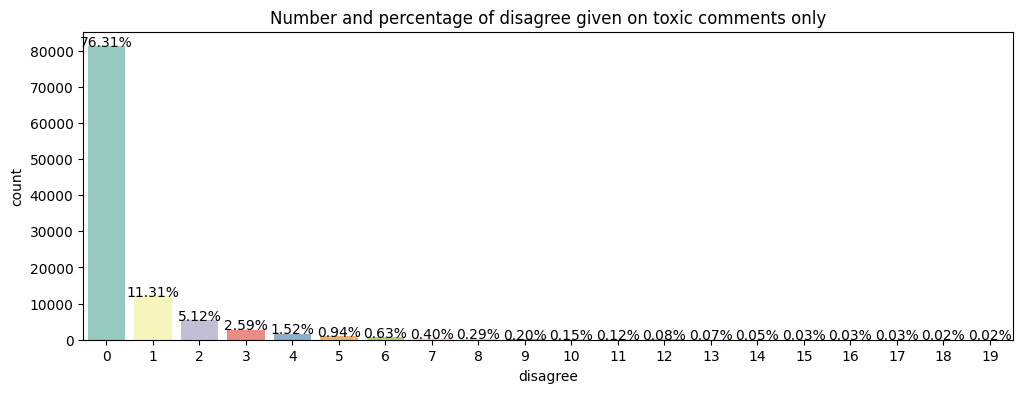

In [29]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

### 5. Comments_text Feature:

In [30]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

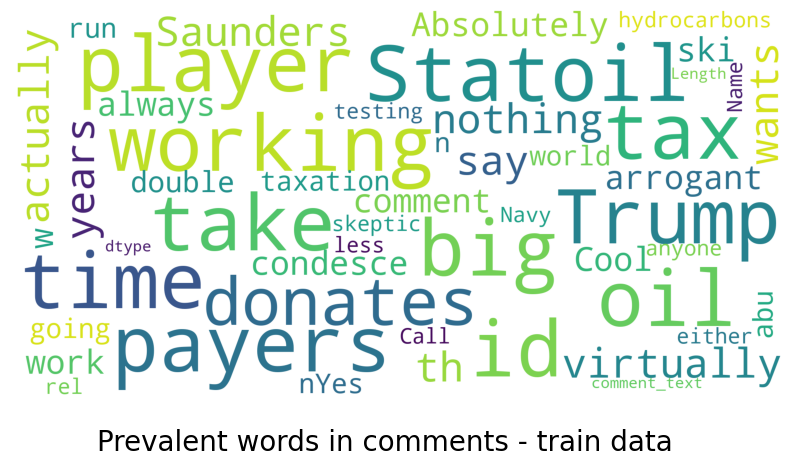

In [31]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

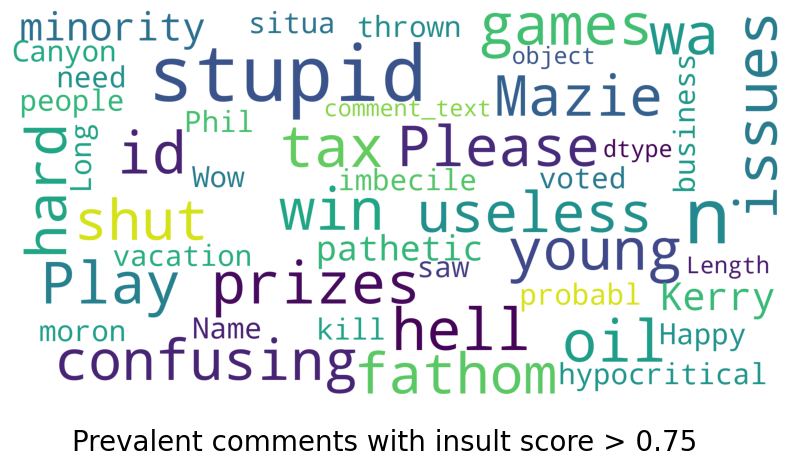

In [32]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

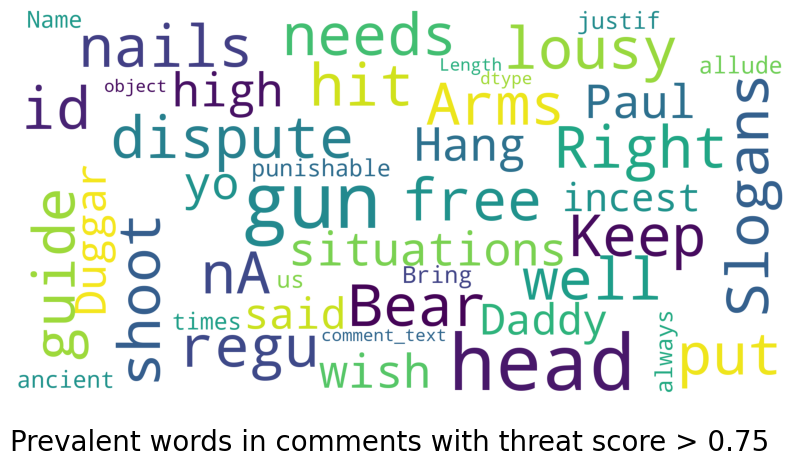

In [33]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

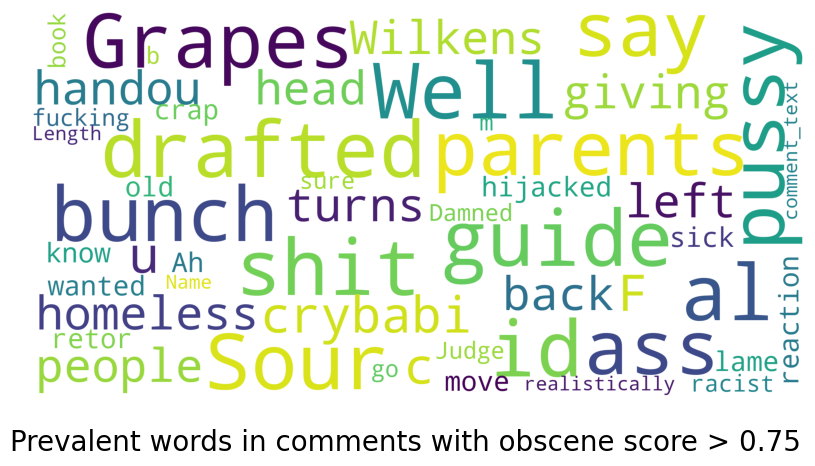

In [34]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

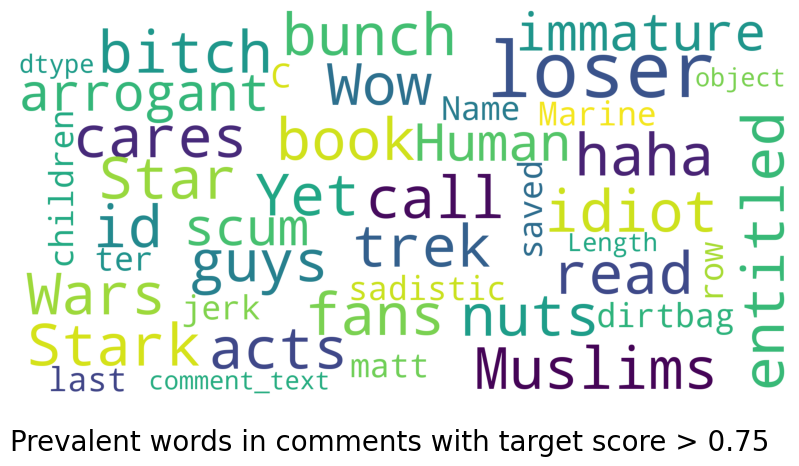

In [35]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

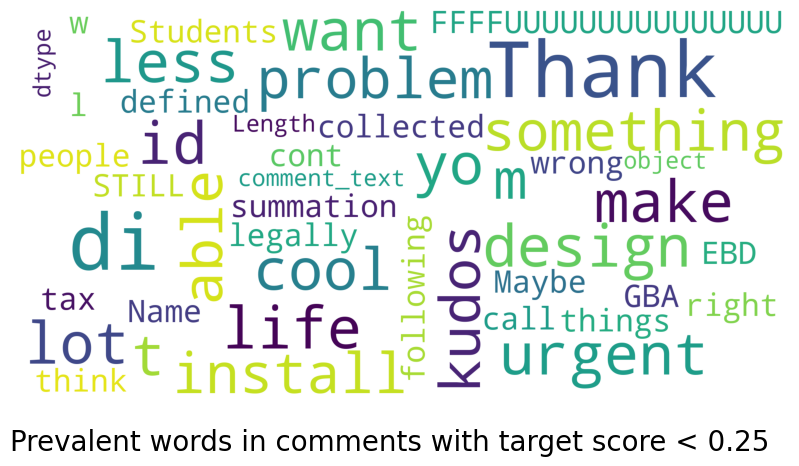

In [36]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

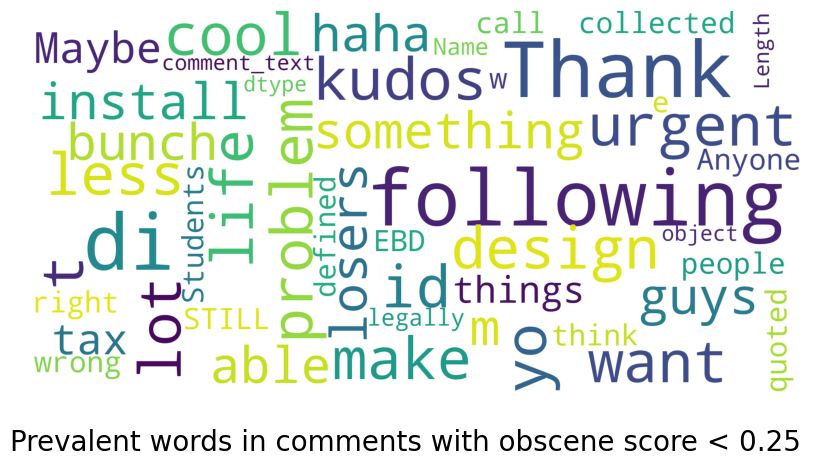

In [37]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

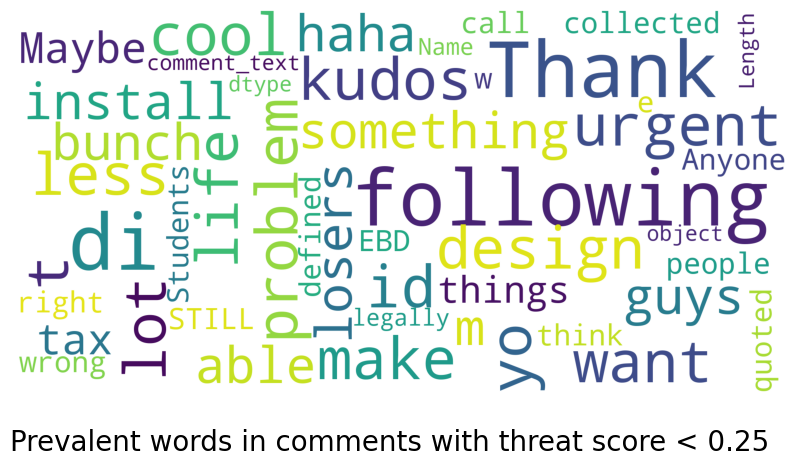

In [38]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

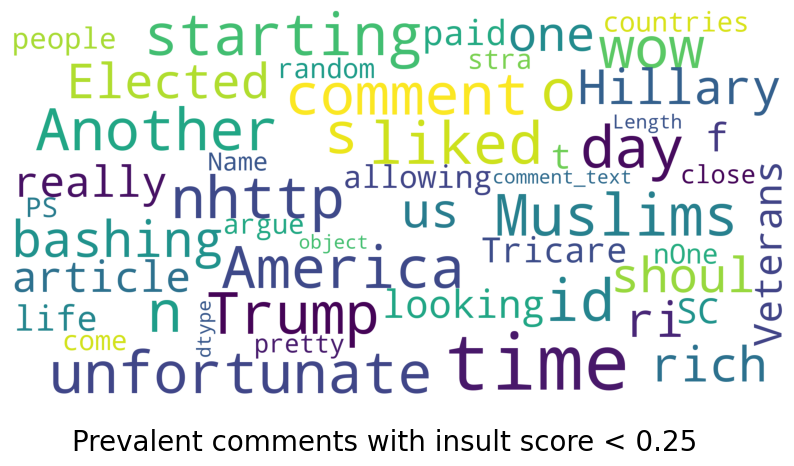

In [39]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [40]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [49]:
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter

# Define the preprocess function
def preprocess(text_string):
    # Your preprocessing steps here
    return text_string.lower()  # Example: Convert text to lowercase

# Load and preprocess data
text_data = train_df['comment_text'].fillna('').tolist()
preprocessed_data = [preprocess(text) for text in text_data]

# Tokenize text on GPU
tokenizer = get_tokenizer("basic_english")
tokenized_data = [tokenizer(text) for text in preprocessed_data]

# Build vocabulary
counter = Counter()
for tokens in tokenized_data:
    counter.update(tokens)
vocab = {token: idx for idx, (token, _) in enumerate(counter.items())}

# Convert tokenized data to PyTorch tensors on GPU
max_length = 100  # Define the maximum sequence length
tensor_data = []
for tokens in tokenized_data:
    token_ids = [vocab.get(token, 0) for token in tokens]  # Use 0 for unknown tokens
    token_ids = token_ids[:max_length]  # Trim to max length
    token_ids += [0] * (max_length - len(token_ids))  # Pad sequences with zeros
    tensor_data.append(torch.tensor(token_ids, device=device))

# Now `tensor_data` contains preprocessed text data as PyTorch tensors on the GPU


In [50]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [51]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 94.9 ms, sys: 15 ms, total: 110 ms
Wall time: 108 ms


In [53]:
# Define the preprocess function
def preprocess(text_string):
    # Your preprocessing steps here
    return text_string.lower()  # Example: Convert text to lowercase

# Load and preprocess data
train_df['preprocessed_text'] = train_df['comment_text'].fillna('').apply(preprocess)

# Select features and target
feature = train_df[['preprocessed_text']]
output = train_df[['target']]

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(feature, output, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)


(1443899, 1)
(360975, 1)
(1443899, 1)
(360975, 1)


In [54]:
X_train.head()

,preprocessed_text
id,
5650796,you could have written the same article on alm...
5815600,"""i bet he's never even met the cardinal but se..."
5657208,it's hard to understand how so many people eff...
5614373,"no, ceo's get rich by have good money manageme..."
5703960,fox news is more polished than local conservat...


In [55]:
X_cv.head()

,preprocessed_text
id,
593336,what a breathe of fresh air to have someone wh...
756192,your jewish friends were the ones who told you...
5407051,possible collusion by trump and his affiliates...
5808132,exactly. we need a % of gdp spending cap at t...
557013,"by your own comment, even if some of them vote..."


In [56]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,[ integrity means that you pay your debts.]\n\...
7097321,this is malfeasance by the administrator and t...
7097322,@rmiller101 - spoken like a true elitist. but ...
7097323,"paul: thank you for your kind words. i do, in..."
7097324,sorry you missed high school. eisenhower sent ...


In [59]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [60]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BoW):

In [61]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1443899, 30000)
(360975, 30000)
(97320, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [62]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.022593235306457144
Mean Squared Error on cv set:  0.022957270027839535
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.022059642416008933
Mean Squared Error on cv set:  0.02292543600245922
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02459392957244882
Mean Squared Error on cv set:  0.024857686044273457
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.022235360986921752
Mean Squared Error on cv set:  0.022976451101556324
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.033126673210930706
Mean Squared Error on cv set:  0.033400805666499514
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.023171797555973487
Mean Squared Error on cv set:  0.02372462117681359
**************************************

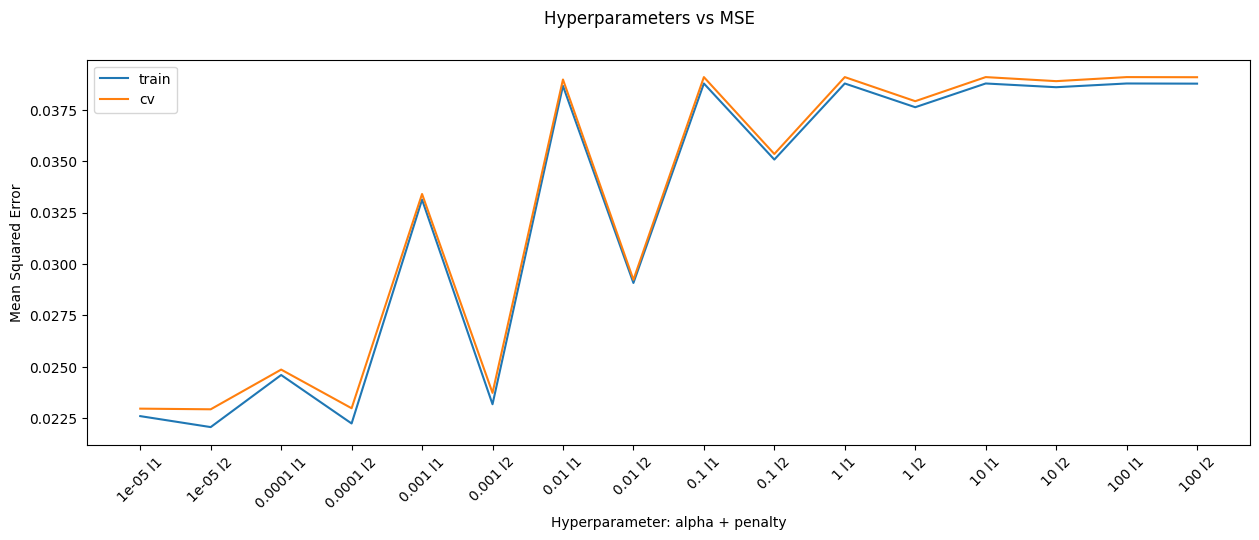

In [63]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [64]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 1.1.2 Feature Importance:

In [66]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]


,weights
idiot,0.413590
idiots,0.402652
stupid,0.341527
stupidity,0.341366
idiotic,0.338262
moron,0.327911
hypocrite,0.324468
pathetic,0.301571
ass,0.291701
crap,0.283365


In [67]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
ignorant of,-0.076974
knee jerk,-0.073878
not racist,-0.041156
shut down,-0.039126
winners,-0.038992
black market,-0.037133
and white,-0.034767
sick of,-0.034682
cans,-0.034000
the brain,-0.033655


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [68]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.034268755787405666
Mean Squared Error on cv set:  0.03454978507989042
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03426875578740566
Mean Squared Error on cv set:  0.03454978507989041
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03426875578740567
Mean Squared Error on cv set:  0.034549785079890406
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03301849015913921
Mean Squared Error on cv set:  0.03329492719620278
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.033018772141016964
Mean Squared Error on cv set:  0.03329644302225381
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tra

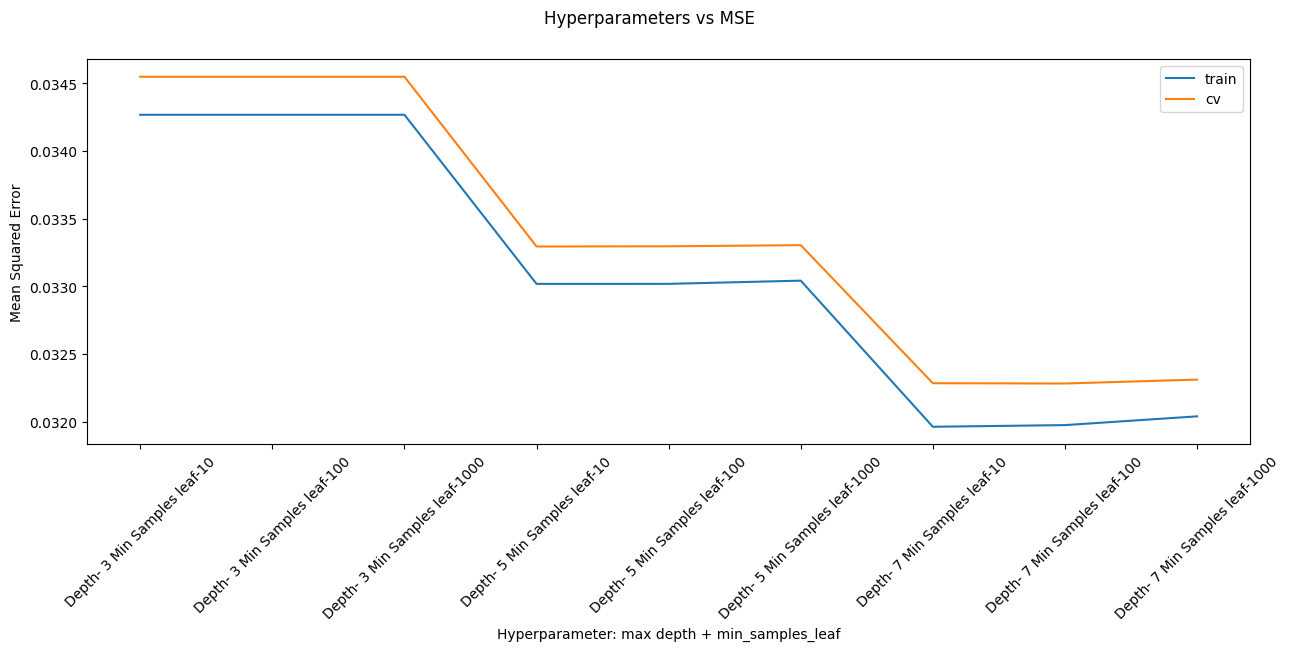

In [69]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [70]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [71]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.369172
idiot,0.170990
idiots,0.104529
ignorant,0.091098
pathetic,0.079246
stupidity,0.072359
dumb,0.067157
the,0.031554
to,0.007252
ignorant of,0.002066


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [72]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1443899, 30000)
(360975, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [73]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.028905273730836505
Mean Squared Error on cv set:  0.0290905127806928
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.02760971040274341
Mean Squared Error on cv set:  0.027841082026644332
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.03400516454253317
Mean Squared Error on cv set:  0.034236232358921266
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.02824824896812284
Mean Squared Error on cv set:  0.028484153770264475
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.038776739858536906
Mean Squared Error on cv set:  0.0390875463442213
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.032540577731178924
Mean Squared Error on cv set:  0.03280019292992664
*******************************************

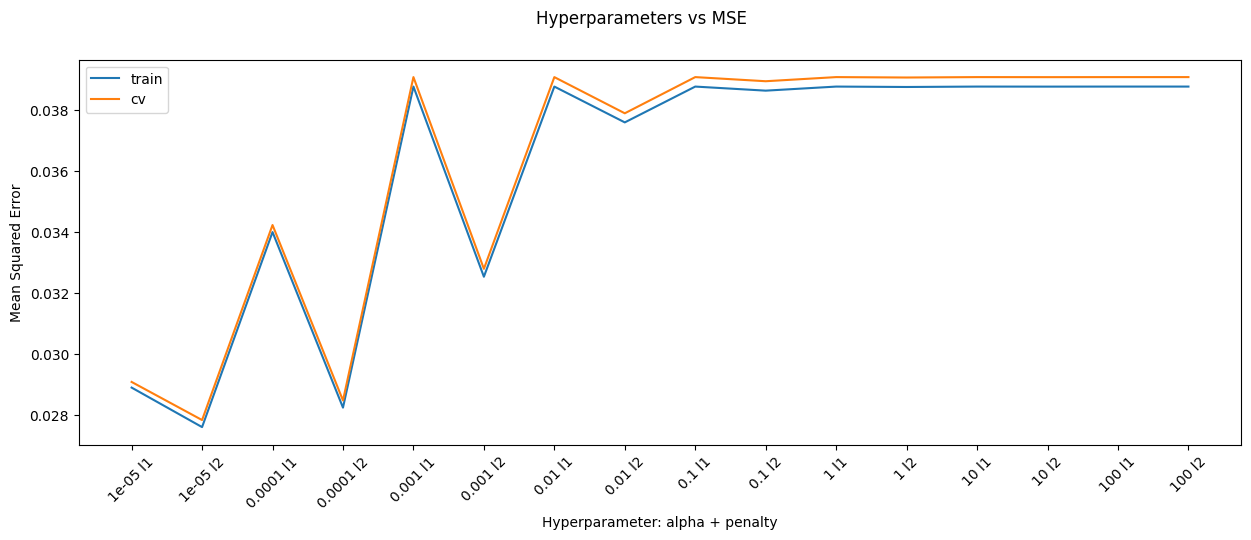

In [74]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [77]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
top_20_features = df.sort_values("weights", ascending=False).iloc[0:20,:]


In [78]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank you,-0.107461
not,-0.105820
in,-0.091734
which,-0.091447
thank,-0.086761
good,-0.085558
there,-0.083821
great,-0.082763
new,-0.080135
point,-0.077569


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [79]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03421842375477757
Mean Squared Error on cv set:  0.034497135389037016
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.034218423754777585
Mean Squared Error on cv set:  0.034497135389037016
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.034218423754777585
Mean Squared Error on cv set:  0.034497135389037016
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03295642570742094
Mean Squared Error on cv set:  0.03323419186698183
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03295819899992387
Mean Squared Error on cv set:  0.033233093136292725
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on 

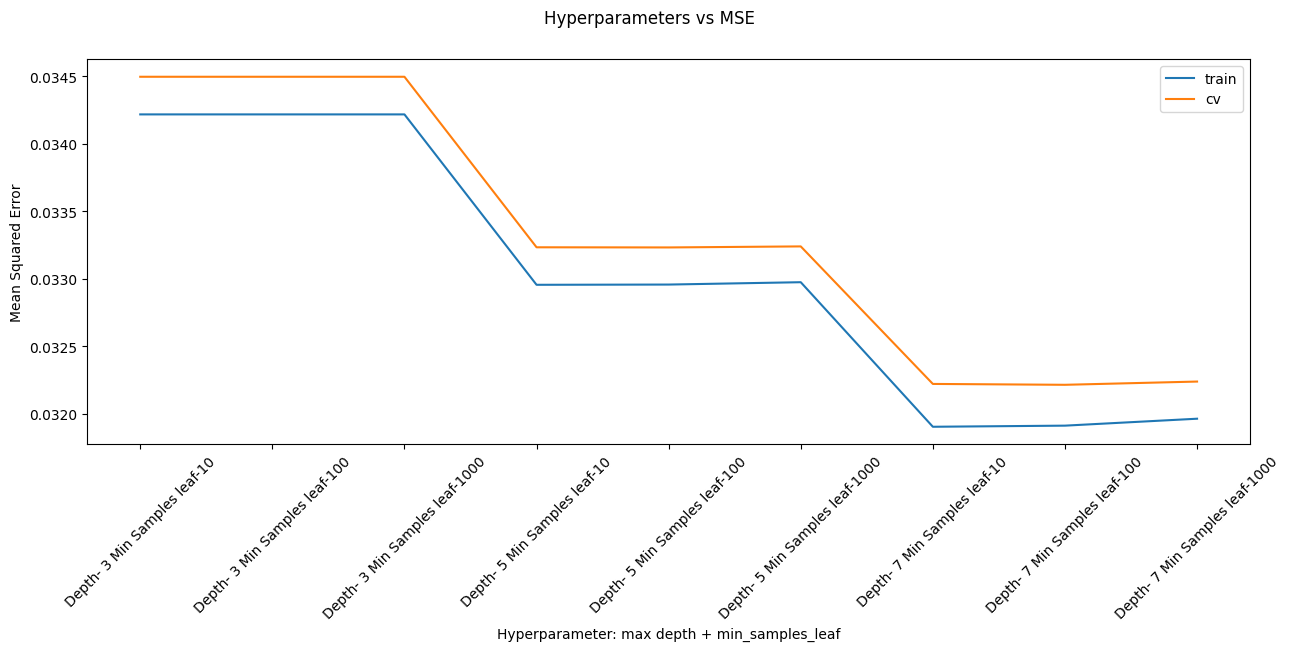

In [80]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [81]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.386742
idiot,0.176592
idiots,0.107857
ignorant,0.099384
pathetic,0.083025
stupidity,0.074921
dumb,0.066556
ignorant of,0.002040
you,0.000721
the,0.000289


### 3. Features for LSTM:

In [1]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [11]:
import pandas as pd
import numpy as np  # Add this import statement

# Assuming train_df contains preprocessed_text and target columns
train_data = {
    'preprocessed_text': ['text 1', 'text 2', 'text 3'],
    'target': [0, 1, 0]  # Example target values, replace with your actual targets
}

train_df = pd.DataFrame(train_data)

# Now you can access the 'preprocessed_text' and 'target' columns
X_train = train_df['preprocessed_text']
y_train = train_df['target']

# Assuming LSTMFeaturization class is defined
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train)  # Assuming the fit() method only takes X_train as input


In [24]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

# Load test data from CSV file
test_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

# Check if the 'preprocessed_text' column exists in test_df
if 'preprocessed_text' in test_df.columns:
    # Convert Series to list
    X_test = test_df['preprocessed_text'].tolist()

    # Now you can proceed with the rest of your code
    import keras

    # Assuming X_train, X_test, and X_cv contain the preprocessed text data

    # Remove ['preprocessed_text'] when calling transform method
    lstm_train = lstmfeat.transform(X_train)
    lstm_test = lstmfeat.transform(X_test)
    lstm_cv = lstmfeat.transform(X_cv)
else:
    print("The 'preprocessed_text' column does not exist in the test data.")


The 'preprocessed_text' column does not exist in the test data.


In [41]:
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences

# Define stopwords to be removed
stop_words = set(stopwords.words('english'))

# Define a preprocess function to clean and tokenize the text data
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and digits using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Split the data into training and cross-validation sets
X_train, X_cv, y_train, y_cv = train_test_split(train_df['preprocessed_text'], train_df['target'], test_size=0.2, random_state=42)

# Now you can transform X_cv using lstmfeat
lstm_cv = lstmfeat.transform(X_cv)

# Define X_test
X_test = test_df['comment_text'].fillna('').tolist()  # Adjust column name if needed

# Preprocess X_test
X_test_preprocessed = [preprocess(text) for text in X_test]

# Tokenize and pad the sequences
max_seq_length = 100  # Adjust as needed
word_to_index = {word: i for i, word in enumerate(lstmfeat.word_mapping.keys())}
X_test_tokenized = [[word_to_index.get(word, 0) for word in word_tokenize(text)] for text in X_test_preprocessed]
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_seq_length)

# Convert padded sequences back to sentences
X_test_sentences = [' '.join(map(str, tokens)) for tokens in X_test_padded]

# Transform X_test using lstmfeat
lstm_test = lstmfeat.transform(X_test_sentences)

# Print the shapes
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)


(3, 350)
(1, 350)
(97320, 350)


In [43]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [47]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words

model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [53]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming lstmfeat is already defined
# Assuming train_df and test_df are already defined

# Create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length))  # Removed input_length argument
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

# Print the model summary
print(model.summary())

# Split the data into training and cross-validation sets
X_train, X_cv, y_train, y_cv = train_test_split(train_df['preprocessed_text'], train_df['target'], test_size=0.2, random_state=42)

# Assuming X_test contains the preprocessed text data
X_test = test_df['comment_text'].fillna('').tolist()  # Adjust column name if needed

# Define the filepath for saving model weights
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
# Check the shapes of lstm_train and y_train
print("lstm_train shape:", lstm_train.shape)
print("y_train shape:", y_train.shape)

# Ensure the shapes match
if lstm_train.shape[0] != y_train.shape[0]:
    # If not, adjust the shapes to match
    min_samples = min(lstm_train.shape[0], y_train.shape[0])
    lstm_train = lstm_train[:min_samples]
    y_train = y_train[:min_samples]
    print("Shapes adjusted to match.")

# Now both arrays should have the same number of samples
print("lstm_train shape after adjustment:", lstm_train.shape)
print("y_train shape after adjustment:", y_train.shape)

# Now you can proceed with model training
history = model.fit(lstm_train, y_train, epochs=5, batch_size=2048, validation_data=(lstm_cv, y_cv), verbose=1, callbacks=callbacks_list)


lstm_train shape: (3, 350)
y_train shape: (2,)
Shapes adjusted to match.
lstm_train shape after adjustment: (2, 350)
y_train shape after adjustment: (2,)
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.2501 - mse: 0.2501
Epoch 1: val_loss improved from inf to 0.25114, saving model to weights-improvement-01-0.25.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2501 - mse: 0.2501 - val_loss: 0.2511 - val_mse: 0.2511
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2500 - mse: 0.2500
Epoch 2: val_loss improved from 0.25114 to 0.24922, saving model to weights-improvement-02-0.25.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2500 - mse: 0.2500 - val_loss: 0.2492 - val_mse: 0.2492
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2498 - mse: 0.2498
Epoch 3: val_loss did not improve from 0.24922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2498 - mse: 0.2498 - val_loss: 0.2507 - val_mse: 0.2507
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.

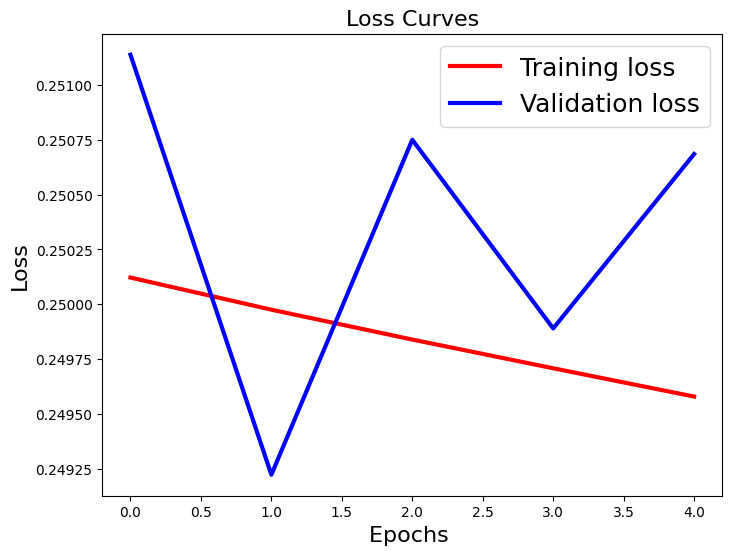

In [58]:
import matplotlib.pyplot as plt

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()


## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02281
        - CV MSE Loss: 0.02326
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0310
        - CV MSE Loss: 0.03128
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02556
        - CV MSE Loss: 0.02584
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03073
        - CV MSE Loss: 0.03122
3. **LSTM:**
    - Train MSE Loss: 0.0157
    - CV MSE Loss: 0.0162